# **Capstone Project C22-078**

* M319X0851 - Andrew Benedictus Jamesie  
* M319Y0854 - Cheliza Sriayu Simarsoit  
* M248X0512 - A. Gilang Aleyusta Savada  
* M182Y0310 - Ades Tikaningsih  

***Project Theme***:  
Solusi Konservasi dan Pengelolaan Sumber Daya Alam

***Project Title***:  
Aplikasi Pendeteksi Kualitas Air sebagai Upaya Pengelolaan Sumber Daya Air yang Lebih Baik dengan Menggunakan Metode Deep Learning Berbasis Website

***Project Name***:  
Jernihin

# **1. *Library Import***

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.utils import np_utils
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout

from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# **2. *Data Loading***

## 2.1 *Dataset Download*

https://data.amerigeoss.org/dataset/wqi-parameter-scores-1994-2013-b0941

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
water = pd.read_csv('drive/MyDrive/Dataset/WQI_Parameter_Scores_1994-2013.csv')
water.head()

,Station,Station Name,Year,Overall WQI,WQI FC,WQI Oxy,WQI pH,WQI TSS,WQI Temp,WQI TPN,WQI TP,WQI Turb,Location 1
0,16A070,Skokomish R nr Potlatch,1996.0,87,91,85,95,78,81,99,84,69,POINT (-123.1771 47.3098)
1,16A070,Skokomish R nr Potlatch,1997.0,86,78,84,77,85,90,99,72,80,POINT (-123.1771 47.3098)
2,16A070,Skokomish R nr Potlatch,1998.0,75,90,79,88,61,90,98,71,49,POINT (-123.1771 47.3098)
3,16A070,Skokomish R nr Potlatch,1999.0,87,88,80,88,75,95,100,79,71,POINT (-123.1771 47.3098)
4,16A070,Skokomish R nr Potlatch,2000.0,95,93,86,96,84,90,100,84,87,POINT (-123.1771 47.3098)


## 2.2 *Dataset Preparation*

### 2.2.1 *Drop Unnecessary Features*

In [ ]:
water = water.drop(columns=['Station', 'Station Name', 'Year', 'Location 1'])

### 2.2.2 *Rename Columns*

In [ ]:
water = water.rename(columns={
    'Overall WQI' : 'WQI',
    'WQI FC'      : 'Fecal',
    'WQI Oxy'     : 'Oxygen',
    'WQI pH'      : 'pH',
    'WQI TSS'     : 'Tot_Sediment', # Total Suspended Sediment
    'WQI Temp'    : 'Temp',
    'WQI TPN'     : 'Nitrogen',
    'WQI TP'      : 'Phosphorus',
    'WQI Turb'    : 'Turbidity',
})

### 2.2.3 *New Column Quality Classification*

http://pubs.sciepub.com/ajwr/1/3/3

In [ ]:
# Canadian Council of Ministers of the Environment Water Quality Index (CCME WQI)
# 95 - 100 Exellent
# 80 - 94  Good
# 60 - 79  Fair
# 45 - 59  Marginal
# 0  - 44  Poor

conditions = [
    (water.WQI >= 95) & (water.WQI <= 100),
    (water.WQI >= 80) & (water.WQI <= 94),
    (water.WQI >= 60) & (water.WQI <= 79),
    (water.WQI >= 45) & (water.WQI <= 59),
    (water.WQI >= 0)  & (water.WQI <= 44),
]

values = [5, 4, 3, 2, 1]

water['Quality'] = np.select(conditions, values)

In [ ]:
water = water.drop(columns=['WQI'])
water.head()

,Fecal,Oxygen,pH,Tot_Sediment,Temp,Nitrogen,Phosphorus,Turbidity,Quality
0,91,85,95,78,81,99,84,69,4
1,78,84,77,85,90,99,72,80,4
2,90,79,88,61,90,98,71,49,3
3,88,80,88,75,95,100,79,71,4
4,93,86,96,84,90,100,84,87,5


# **3. *Data Understanding***

## 3.1 Menampilkan Data pada Dataframe `water`

In [ ]:
water

,Fecal,Oxygen,pH,Tot_Sediment,Temp,Nitrogen,Phosphorus,Turbidity,Quality
0,91,85,95,78,81,99,84,69,4
1,78,84,77,85,90,99,72,80,4
2,90,79,88,61,90,98,71,49,3
3,88,80,88,75,95,100,79,71,4
4,93,86,96,84,90,100,84,87,5
...,...,...,...,...,...,...,...,...,...
966,85,89,92,68,68,52,58,75,3
967,76,78,96,78,65,77,73,81,3
968,78,87,91,78,78,57,69,82,4
969,67,88,94,87,77,67,88,93,3


## 3.2 *Exploratory Data Analysis* (EDA)

### 3.2.1 Deskripsi Variabel

In [ ]:
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Fecal         971 non-null    int64
 1   Oxygen        971 non-null    int64
 2   pH            971 non-null    int64
 3   Tot_Sediment  971 non-null    int64
 4   Temp          971 non-null    int64
 5   Nitrogen      971 non-null    int64
 6   Phosphorus    971 non-null    int64
 7   Turbidity     971 non-null    int64
 8   Quality       971 non-null    int64
dtypes: int64(9)
memory usage: 68.4 KB


### 3.2.2 Deskripsi Statistik

In [ ]:
water.describe()

,Fecal,Oxygen,pH,Tot_Sediment,Temp,Nitrogen,Phosphorus,Turbidity,Quality
count,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000
mean,86.833162,85.698249,86.085479,66.909372,76.128733,80.933059,73.656025,68.302781,3.238929
std,10.450816,6.701022,9.806052,19.998196,11.955368,22.239897,21.426718,20.767664,0.816435
min,0.000000,51.000000,43.000000,0.000000,17.000000,0.000000,0.000000,1.000000,1.000000
25%,82.000000,81.000000,80.000000,55.000000,69.000000,77.000000,61.000000,57.500000,3.000000
50%,88.000000,86.000000,89.000000,71.000000,78.000000,89.000000,78.000000,72.000000,3.000000
75%,94.000000,91.000000,94.000000,82.000000,85.000000,97.000000,91.000000,84.000000,4.000000
max,100.000000,100.000000,99.000000,100.000000,100.000000,100.000000,100.000000,100.000000,5.000000


### 3.2.3 *Missing Value Handling*

In [ ]:
water.isnull().sum()

Fecal           0
Oxygen          0
pH              0
Tot_Sediment    0
Temp            0
Nitrogen        0
Phosphorus      0
Turbidity       0
Quality         0
dtype: int64

### 3.2.4 *Outliers Handling*

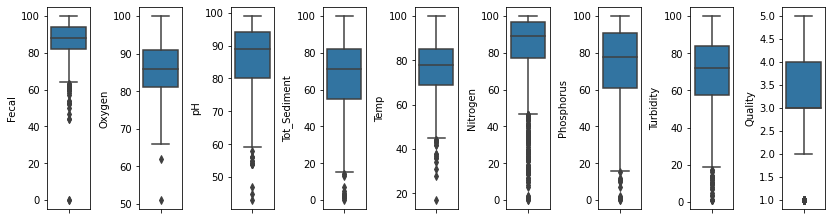

In [ ]:
fig, axes = plt.subplots(1, 9, figsize=(11.5, 3))
count = 0
axes = axes.flatten()

for i, value in water.items():
    sns.boxplot(ax=axes[count], y=i, data=water)
    count += 1

plt.tight_layout(pad=0.5, h_pad=3, w_pad=0.8)

In [ ]:
Q1 = water.quantile(0.25)
Q3 = water.quantile(0.75)

IQR = Q3 - Q1

water = water[~((water < (Q1 - 1.5*IQR)) | (water > (Q3 + 1.5*IQR))).any(axis=1)]

water.shape

(805, 9)

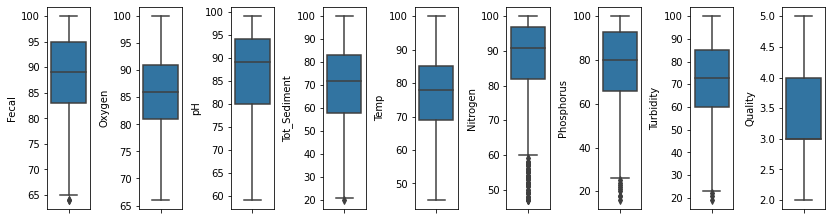

In [ ]:
fig, axes = plt.subplots(1, 9, figsize=(11.5, 3))
count = 0
axes = axes.flatten()

for i, value in water.items():
    sns.boxplot(ax=axes[count], y=i, data=water)
    count += 1

plt.tight_layout(pad=0.5, h_pad=3, w_pad=0.8)

### 3.2.5 *Univariate Analysis*

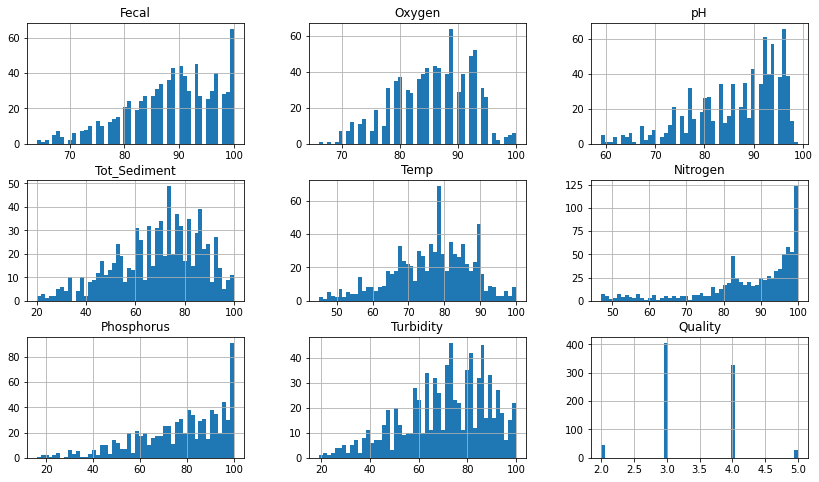

In [ ]:
water.hist(bins=50, figsize=(14, 8))
plt.show()

### 3.2.6 *Multivariate Analysis*

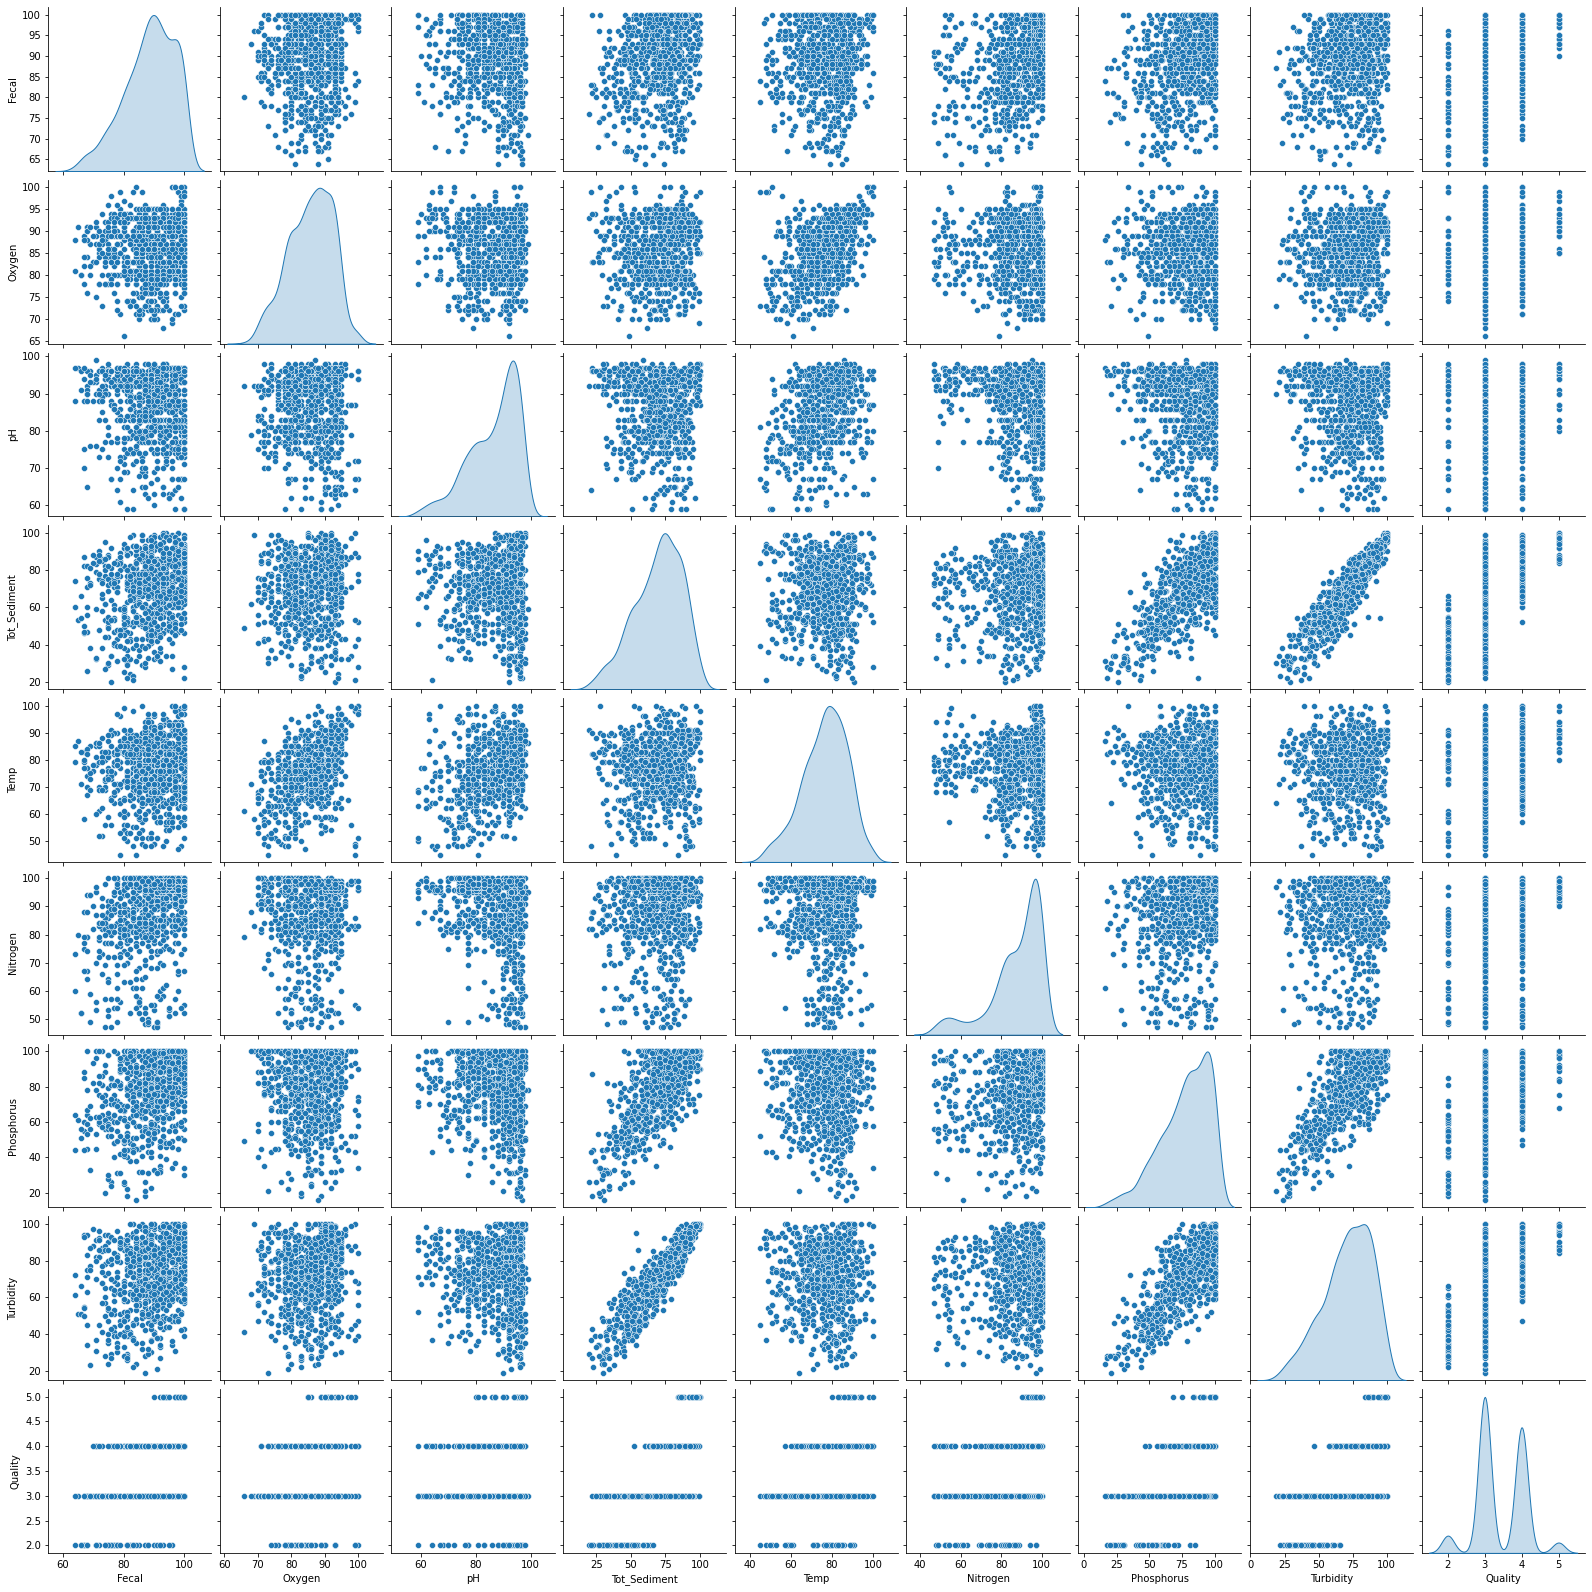

In [ ]:
sns.pairplot(water, diag_kind='kde')

### 3.2.7 *Heatmap Correlation Matrix*

Text(0.5, 1.0, 'Numeric Features Correlation Matrix')

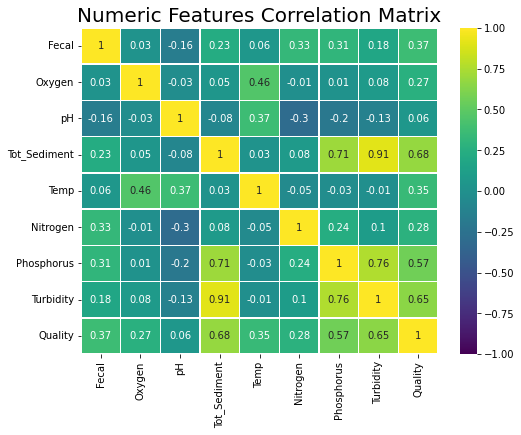

In [ ]:
plt.figure(figsize=(8, 6))

sns.heatmap(
    data       = water.corr().round(2),
    vmin       = -1,
    vmax       = 1,
    cmap       = 'viridis',
    annot      = True,
    linewidths = .5
)

plt.title('Numeric Features Correlation Matrix', size=20)

# **4. *Data Preparation***

## 4.1 *One-Hot Encoding*

In [ ]:
dataset = water.values

In [ ]:
x = dataset[:,4:11].astype(float)
y = dataset[:,8]

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encodedY = encoder.transform(y)

y = np_utils.to_categorical(encodedY)

In [ ]:
y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
y.shape

(805, 4)

## 4.2 *Split Data*

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=20221107)

print(f'Total all sample : {len(x)}')
print(f'Total data train : {len(xTrain)}')
print(f'Total data test  : {len(xTest)}')

Total all sample : 805
Total data train : 644
Total data test  : 161


# **5. *Model Development***

In [ ]:
model = Sequential([
    Dense(64, input_dim=5, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer = 'adam',
    loss      = 'categorical_crossentropy',
    metrics   = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
Total params: 3,164
Trainable params: 3,164
Non-trainabl

In [ ]:
class stopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.98):
            print('\naccuracy and val_accuracy reach > 98%')
            self.model.stop_training = True

stopTraining = stopCallback()

In [ ]:
epoch = 200

history = model.fit(
    xTrain,
    yTrain,
    validation_data = (xTest, yTest),
    epochs          = epoch,
    batch_size      = 4,
    verbose         = 2,
    # callbacks       = [stopTraining]
)

Epoch 1/200
161/161 - 1s - loss: 1.4537 - accuracy: 0.5093 - val_loss: 0.9516 - val_accuracy: 0.4534 - 1s/epoch - 9ms/step
Epoch 2/200
161/161 - 0s - loss: 1.0178 - accuracy: 0.5280 - val_loss: 0.9251 - val_accuracy: 0.4534 - 405ms/epoch - 3ms/step
Epoch 3/200
161/161 - 0s - loss: 0.9880 - accuracy: 0.5217 - val_loss: 0.9139 - val_accuracy: 0.6335 - 373ms/epoch - 2ms/step
Epoch 4/200
161/161 - 0s - loss: 0.9616 - accuracy: 0.5761 - val_loss: 0.8839 - val_accuracy: 0.6211 - 411ms/epoch - 3ms/step
Epoch 5/200
161/161 - 0s - loss: 0.9160 - accuracy: 0.5776 - val_loss: 0.8666 - val_accuracy: 0.6522 - 390ms/epoch - 2ms/step
Epoch 6/200
161/161 - 0s - loss: 0.8954 - accuracy: 0.5947 - val_loss: 0.8228 - val_accuracy: 0.7081 - 345ms/epoch - 2ms/step
Epoch 7/200
161/161 - 0s - loss: 0.8713 - accuracy: 0.6149 - val_loss: 0.8138 - val_accuracy: 0.6894 - 369ms/epoch - 2ms/step
Epoch 8/200
161/161 - 0s - loss: 0.8626 - accuracy: 0.6227 - val_loss: 0.7978 - val_accuracy: 0.6832 - 384ms/epoch - 2ms/

# **6. *Model Evaluation***

In [ ]:
accuracy     = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss         = history.history['loss']
val_loss     = history.history['val_loss']

In [ ]:
print(f'Max Training Accuracy: {max(accuracy)}')
print(f'Max Validation Accuracy: {max(val_accuracy)}\n')
print(f'Min Training Loss: {min(loss)}')
print(f'Min Validation Loss: {min(val_loss)}')

Max Training Accuracy: 0.9751552939414978
Max Validation Accuracy: 1.0

Min Training Loss: 0.07037824392318726
Min Validation Loss: 0.010348552837967873


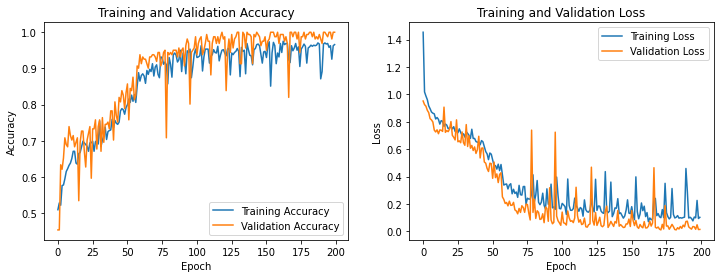

In [ ]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy,     label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(loss,     label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [ ]:
lossTest, accTest = model.evaluate(xTest, yTest, batch_size=4)
print(f'\nLoss Test: {lossTest}')
print(f'Accuracy Test: {accTest*100}')

41/41 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 1.0000

Loss Test: 0.014108738861978054
Accuracy Test: 100.0


# **7. *Model Export Deployment***

In [ ]:
model.save('model.h5')

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 1.8 MB/s 
     |████████████████████████████████| 16.2 MB 2.3 MB/s 
     |████████████████████████████████| 40 kB 4.5 MB/s 
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 189 kB 70.5 MB/s 
     |████████████████████████████████| 8.3 MB 54.5 MB/s 
     |████████████████████████████████| 237 kB 69.5 MB/s 
     |████████████████████████████████| 154 kB 69.1 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 
     |████████████████████████████████| 439 kB 68.7 MB/s 
     |████████████████████████████████| 1.7 MB 28.4 MB/s 
     |████████████████████████████████| 6.0 MB 51.0 MB/s 
     |████████████████████████████████| 85 kB 3.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
     

In [ ]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2022-12-01 05:01:31.357459: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-01 05:01:31.357738: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-01 05:01:31.357771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# **8. *Model Test***

In [ ]:
del model

In [ ]:
filePath = '/content/model.h5'
model = load_model(filePath, compile=True)

In [ ]:
x

array([[81., 99., 84., 69.,  4.],
       [90., 99., 72., 80.,  4.],
       [90., 98., 71., 49.,  3.],
       ...,
       [78., 57., 69., 82.,  4.],
       [77., 67., 88., 93.,  3.],
       [84., 98., 91., 92.,  4.]])

In [ ]:
y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
score = model.evaluate(x, y, verbose=0)
print(f'{model.metrics_names[0]}: {round(score[0], 4)}')
print(f'{model.metrics_names[1]}: {round(score[1]*100, 4)}%')

loss: 0.0097
accuracy: 100.0%
